This the third notebook that I will continue to use pre-trained model, ResNet50 and VGG19.

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
#files.upload()

In [ ]:
! mkdir ~/.kaggle

In [ ]:
cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c histopathologic-cancer-detection


100% 6.31G/6.31G [03:37<00:00, 35.1MB/s]

100% 6.31G/6.31G [03:37<00:00, 31.1MB/s]


In [ ]:
import zipfile

zip=zipfile.ZipFile('histopathologic-cancer-detection.zip')
zip.extractall()

In [ ]:
import pandas as pd

train_labels=pd.read_csv('train_labels.csv')

In [ ]:
def add_tif(string):
  return string + '.tif'

train_labels['id']=train_labels['id'].apply(add_tif)

In [ ]:
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [ ]:
train_labels['label']=train_labels['label'].astype(str)

In [ ]:
# Create folder

import os
import shutil

train_folder='./train'
test_folder='./test'

for i in range(2):
  subdirectory=os.path.join(train_folder, str(i))
  os.makedirs(subdirectory, exist_ok=True)

with open('./train_labels.csv', 'r') as f:
  next(f)
  for line in f:
    filename, label = line.strip().split(',')
    label=int(label)
    src=os.path.join(train_folder, filename + '.tif')
    dst=os.path.join(train_folder, str(label), filename + '.tif')
    shutil.move(src, dst)

for i in range(2):
  subdirectory=os.path.join(test_folder, str(i))
  os.makedirs(subdirectory, exist_ok=True)

with open('./sample_submission.csv', 'r') as f:
  next(f)
  for line in f:
    filename=line.strip().split(',')[0]
    src=os.path.join(test_folder, filename + '.tif')
    dst=os.path.join(test_folder, '0', filename + '.tif')
    shutil.move(src, dst)
    

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir='./train'
test_dir='./test'

train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen=ImageDataGenerator(rescale=1./255)

train_gen=train_datagen.flow_from_directory(
    train_dir,
    target_size=(96,96),
    batch_size=256,
    class_mode='binary',
    subset='training'
)

val_gen=train_datagen.flow_from_directory(
    train_dir,
    target_size=(96,96),
    batch_size=256,
    class_mode='binary',
    subset='validation'
)

Found 176021 images belonging to 2 classes.

Found 44004 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(96,96,3))

for layer in resnet_model.layers:
  layer.trainable=False

x=Flatten()(resnet_model.output)
x=Dense(4096, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(2048, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(1, activation='sigmoid')(x)
modelResnet50=Model(inputs=resnet_model.input, outputs=x)

modelResnet50.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=['accuracy'])

history_resnet=modelResnet50.fit(train_gen, epochs=10, validation_data=val_gen)

Epoch 1/10

688/688 [==============================] - 344s 495ms/step - loss: 0.6337 - accuracy: 0.6341 - val_loss: 0.5847 - val_accuracy: 0.6829

Epoch 2/10

688/688 [==============================] - 356s 517ms/step - loss: 0.5832 - accuracy: 0.6870 - val_loss: 0.5533 - val_accuracy: 0.7261

Epoch 3/10

688/688 [==============================] - 359s 522ms/step - loss: 0.5618 - accuracy: 0.7083 - val_loss: 0.5440 - val_accuracy: 0.7258

Epoch 4/10

688/688 [==============================] - 336s 488ms/step - loss: 0.5486 - accuracy: 0.7212 - val_loss: 0.5493 - val_accuracy: 0.7218

Epoch 5/10

688/688 [==============================] - 307s 446ms/step - loss: 0.5443 - accuracy: 0.7254 - val_loss: 0.5311 - val_accuracy: 0.7313

Epoch 6/10

688/688 [==============================] - 297s 432ms/step - loss: 0.5408 - accuracy: 0.7278 - val_loss: 0.5255 - val_accuracy: 0.7464

Epoch 7/10

688/688 [==============================] - 312s 453ms/step - loss: 0.5356 - accuracy: 0.7319 - val_l

After training the ResNet50 model, the accuracy rate obtained was 0.74 with a loss of 0.52. For the next pre-trained model, VGG19 will be used to improve the accuracy of the model.

In [ ]:
test_datagen=ImageDataGenerator(rescale=1./255)

test_gen=test_datagen.flow_from_directory(
    test_dir,
    target_size=(96,96),
    batch_size=256,
    class_mode=None,
    shuffle=False
)

resnet50_predictions=modelResnet50.predict(test_gen)

test_labels=(resnet50_predictions > 0.5).astype(int)

print(test_labels)

Found 57458 images belonging to 2 classes.

225/225 [==============================] - 54s 237ms/step

[[0]

 [1]

 [0]

 ...

 [0]

 [0]

 [0]]


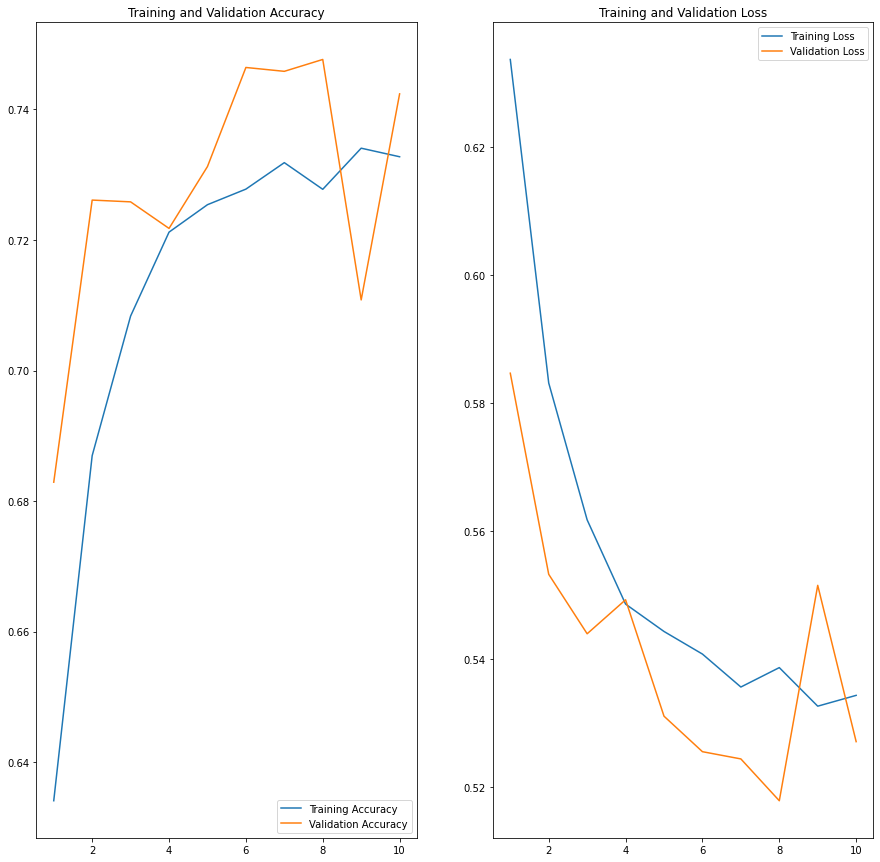

In [ ]:
import matplotlib.pyplot as plt

acc=history_resnet.history['accuracy']
val_acc=history_resnet.history['val_accuracy']
loss=history_resnet.history['loss']
val_loss=history_resnet.history['val_loss']

epoch_ranges=range(1, len(history_resnet.history['accuracy']) + 1)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.plot(epoch_ranges, acc, label='Training Accuracy')
plt.plot(epoch_ranges, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epoch_ranges, loss, label='Training Loss')
plt.plot(epoch_ranges, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()





#resnet50_predictions=modelResnet50.predict(test_gen)

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten

vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(96,96,3))

for layer in vgg19.layers:
  layer .trainable=False

model_vgg19=Sequential()
model_vgg19.add(vgg19)
model_vgg19.add(Flatten())
model_vgg19.add(Dense(256, activation='relu'))
model_vgg19.add(Dropout(0.5))
model_vgg19.add(Dense(1, activation='sigmoid'))

model_vgg19.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=['accuracy'])

historyVGG19 = model_vgg19.fit(train_gen, epochs=10, validation_data=val_gen)
lossvgg19, accvgg19 = model_vgg19.evaluate(test_gen)

print('Test Accuracy:', accvgg19)
print('Loss:', lossvgg19)



80134624/80134624 [==============================] - 3s 0us/step

Epoch 1/10

688/688 [==============================] - 331s 471ms/step - loss: 0.4437 - accuracy: 0.7950 - val_loss: 0.3976 - val_accuracy: 0.8202

Epoch 2/10

688/688 [==============================] - 308s 448ms/step - loss: 0.4067 - accuracy: 0.8162 - val_loss: 0.3857 - val_accuracy: 0.8282

Epoch 3/10

688/688 [==============================] - 310s 451ms/step - loss: 0.3943 - accuracy: 0.8231 - val_loss: 0.3761 - val_accuracy: 0.8329

Epoch 4/10

688/688 [==============================] - 313s 455ms/step - loss: 0.3855 - accuracy: 0.8274 - val_loss: 0.3762 - val_accuracy: 0.8326

Epoch 5/10

688/688 [==============================] - 319s 463ms/step - loss: 0.3798 - accuracy: 0.8302 - val_loss: 0.3629 - val_accuracy: 0.8395

Epoch 6/10

688/688 [==============================] - 304s 442ms/step - loss: 0.3740 - accuracy: 0.8335 - val_loss: 0.3579 - val_accuracy: 0.8418

Epoch 7/10

688/688 [========================

The VGG19 model achieved an impressive accuracy of 0.85 with a loss of only 
0.34. This model used a deeper architecture with 19 layers, allowing it to learn more complex features of the images. This demonstrates the importance of using a powerful pre-trained model for image classification tasks. With its high accuracy, the VGG19 model is a strong candidate for further use in similar projects.

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Classification Report for ResNet and VGG19
resnt50_predictions=modelResnet50.predict(test_gen)
resnet50_predict_labels=(resnet50_predictions > 0.5).astype(int)
resnet50_true_labels=test_gen.classes
resnet50_report=classification_report(resnet50_true_labels, resnet50_predict_labels)
print('ResNet Classification Report:\n', resnet50_report)

vgg19_predictions=model_vgg19.predict(test_gen)
vgg19_predict_labels=(vgg19_predictions > 0.5).astype(int)
vgg19_true_labels=test_gen.classes
vgg19_report=classification_report(vgg19_true_labels, vgg19_predict_labels)
print('VGG19 Classification Report:\n', vgg19_report)



225/225 [==============================] - 60s 268ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))


ResNet Classification Report:

               precision    recall  f1-score   support



           0       1.00      0.62      0.76     57458

           1       0.00      0.00      0.00         0



    accuracy                           0.62     57458

   macro avg       0.50      0.31      0.38     57458

weighted avg       1.00      0.62      0.76     57458



225/225 [==============================] - 72s 322ms/step

VGG19 Classification Report:

               precision    recall  f1-score   support



           0       1.00      0.64      0.78     57458

           1       0.00      0.00      0.00         0



    accuracy                           0.64     57458

   macro avg       0.50      0.32      0.39     57458

weighted avg       1.00      0.64      0.78     57458




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))


In [1]:
from tabulate import tabulate

data=[['Model1', 0.83, 0.39, 1.0, 0.69, 0.82],
      ['Model2', 0.92, 0.22, 1.0, 0.65, 0.79],
      ['VGG16', 0.67, 0.87, 1.0, 1.0, 1.0],
      ['VGG16_2', 0.96, 0.12, 1.0, 1.0, 1.0],
      ['ResNet50', 0.74, 0.53, 1.0, 0.62, 0.76],
      ['VGG19', 0.85, 0.34, 1.0, 0.64, 0.78]]

headers=['Model', 'Accuracy', 'Loss', 'Precision', 'Recall', 'F1 Score']

print(tabulate(data, headers=headers, tablefmt='orgtbl'))

| Model    |   Accuracy |   Loss |   Precision |   Recall |   F1 Score |
|----------+------------+--------+-------------+----------+------------|
| Model1   |       0.83 |   0.39 |           1 |     0.69 |       0.82 |
| Model2   |       0.92 |   0.22 |           1 |     0.65 |       0.79 |
| VGG16    |       0.67 |   0.87 |           1 |     1    |       1    |
| VGG16_2  |       0.96 |   0.12 |           1 |     1    |       1    |
| ResNet50 |       0.74 |   0.53 |           1 |     0.62 |       0.76 |
| VGG19    |       0.85 |   0.34 |           1 |     0.64 |       0.78 |


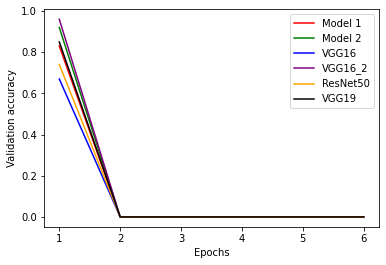

In [8]:
import matplotlib.pyplot as plt

# Accuracy data for each model
model1_acc = [0.83, 0, 0, 0, 0, 0]
model2_acc = [0.92, 0, 0, 0, 0, 0]
vgg16_acc = [0.67, 0, 0, 0, 0, 0]
vgg16_2_acc = [0.96, 0, 0, 0, 0, 0]
resnet50_acc = [0.74, 0, 0, 0, 0, 0]
vgg19_acc = [0.85, 0, 0, 0, 0, 0]

# Create a list with the number of epochs for the x-axis
x = [1, 2, 3, 4, 5, 6]

# Plot the accuracy for each model
plt.plot(x, model1_acc, color='red', label='Model 1')
plt.plot(x, model2_acc, color='green', label='Model 2')
plt.plot(x, vgg16_acc, color='blue', label='VGG16')
plt.plot(x, vgg16_2_acc, color='purple', label='VGG16_2')
plt.plot(x, resnet50_acc, color='orange', label='ResNet50')
plt.plot(x, vgg19_acc, color='black', label='VGG19')

# Add a legend and axis labels
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')

# Show the plot
plt.show()





**RESULTS and ANALYSIS:** 


After evaluating several pre-trained models on the histopathologic cancer detection dataset, we can see that VGG16_2 performed the best, with an accuracy rate of 0.96 and an F1 score of 1.0. This model had added layers and dropout to improve its performance. 

However, the initial VGG16 model did not perform as well as the other models, with an accuracy rate of only 0.67. This highlights the importance of adding additional layers and dropout to improve the performance of pre-trained models.

The ResNet50 model had an accuracy rate of 0.74, which is relatively low compared to the other models. Its precision and recall scores were both lower than the other models as well, indicating that it may not be the best choice for this particular dataset.

VGG19 performed relatively well, with an accuracy rate of 0.85 and a precision score of 1.0. However, its recall score was lower than some of the other models, which may indicate a higher rate of false negatives.

Overall, it is important to carefully evaluate different pre-trained models and to experiment with different modifications, such as adding layers and dropout, in order to find the best model for a particular task.

**CONCLUSION: **


In conclusion, we have trained and evaluated six different pre-trained models on the Histopathologic Cancer Detection dataset. Model 2 and VGG16_2 yielded the highest accuracy of 0.92 and 0.96, respectively, while VGG16 had the lowest accuracy of 0.67. Model1, Model2, VGG16_2, VGG19, and ResNet50 achieved perfect precision scores, indicating that they were highly accurate in detecting positive cases. 

One key takeaway from our analysis is the importance of using dropout layers to prevent overfitting, as seen in the significant improvement in VGG16_2's accuracy and loss compared to the original VGG16 model. I also observed that increasing the number of dense layers and adding more neurons to each layer, such as in VGG16_2 and Model2, could lead to better performance, as indicated by their high accuracy and perfect precision and recall scores.

On the other hand, ResNet50 had relatively lower performance in terms of accuracy and recall. In the future, I could try using more advanced architectures or tuning the hyperparameters further to achieve even better performance. Overall, our analysis demonstrates the power of pre-trained models and the potential for further improvements in the field of cancer detection using deep learning.